In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_clustered = pd.read_csv('data_clutered.csv', index_col=0)

In [8]:
data_clustered.head()

,Postcode,Borough,Street,Latitude,Longitude,Coordinates,Clusters
0,01-355,Bemowo,os. Przyjaźń,52.2374,20.9164,"52.2374, 20.9164",9
1,01-362,Bemowo,pl. Kasztelański,52.2317,20.9159,"52.2317, 20.9159",11
2,01-483,Bemowo,ul. A. B. Dobrowolskiego,52.2577,20.8922,"52.2577, 20.8922",9
3,01-464,Bemowo,ul. A. Bożka,52.2424,20.9160,"52.2424, 20.916",9
4,01-480,Bemowo,ul. A. Einsteina,52.2541,20.8921,"52.2541, 20.8921",9


In [101]:
data_clustered.groupby(['Borough'])[['Clusters']].count()

,Clusters
Borough,
Bemowo,106
Białołęka,184
Bielany,193
Mokotów,354
Ochota,192
Praga-Południe,377
Praga-Północ,144
Rembertów,114
Targówek,267


In [45]:
count = data_clustered.groupby(['Clusters'])[['Latitude']].count()

In [46]:
coords_sum = data_clustered.groupby(['Clusters'])[['Latitude', 'Longitude']].sum().reset_index()

In [54]:
cluster_coords = pd.merge(coords_sum, count, on='Clusters')
cluster_coords.head()

,Clusters,Latitude_x,Longitude,Latitude_y
0,1,3443.8285,1398.2176,66
1,2,5842.8148,2375.7382,112
2,3,1514.1065,614.6249,29
3,4,3706.7838,1503.0260,71
4,5,1931.0794,782.2415,37


In [55]:
cluster_coords = cluster_coords.rename(columns={'Latitude_x': 'Latitude', 'Latitude_y': 'SUM'})

In [56]:
cluster_coords.head()

,Clusters,Latitude,Longitude,SUM
0,1,3443.8285,1398.2176,66
1,2,5842.8148,2375.7382,112
2,3,1514.1065,614.6249,29
3,4,3706.7838,1503.0260,71
4,5,1931.0794,782.2415,37


In [58]:
cluster_coords.tail()

,Clusters,Latitude,Longitude,SUM
42,43,4066.2387,1639.1837,78
43,44,2817.9483,1134.1215,54
44,45,6211.9802,2500.7268,119
45,46,3236.6895,1304.4523,62
46,47,2817.5807,1135.4918,54


In [62]:
cluster_coords['Latitude'][0] / cluster_coords['SUM'][0]

0.7905942378328742

In [63]:
cluster_coords['Longitude'][0] / cluster_coords['SUM'][0]

0.320986593204775

In [65]:
cluster_coords.head(10)

,Clusters,Latitude,Longitude,SUM
0,1,52.179220,21.185115,66
1,2,52.167989,21.211948,112
2,3,52.210569,21.193962,29
3,4,52.208223,21.169380,71
4,5,52.191335,21.141662,37
5,6,52.225298,21.149584,103
6,7,52.261595,21.163015,74
7,8,52.243188,21.129903,92
8,9,52.253410,20.904963,30
9,10,52.204621,20.923807,57


In [66]:
from geopy.geocoders import Nominatim

address = 'Pałac Kultury, Warszawa'

geolocator = Nominatim(user_agent="warsaw")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of center of Warsaw are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of center of Warsaw are 52.2317641, 21.005799675616117.


In [67]:
# create map of Warsaw using latitude and longitude values
map_warsaw = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, cluster in zip(cluster_coords['Latitude'], cluster_coords['Longitude'], cluster_coords['Clusters']):
    label = cluster
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_warsaw)  

map_warsaw
#map_warsaw.save('warsaw_clustered_coordinates.html')

In [134]:
cluster_coords['Postcode'] = 'NaN'
cluster_coords['Borough'] = 'NaN'
cluster_coords.head()

,Clusters,Latitude,Longitude,SUM,Postcode,Borough
0,1,52.179220,21.185115,66,NaN,NaN
1,2,52.167989,21.211948,112,NaN,NaN
2,3,52.210569,21.193962,29,NaN,NaN
3,4,52.208223,21.169380,71,NaN,NaN
4,5,52.191335,21.141662,37,NaN,NaN


In [156]:
# Getting the coordinates data from the LocationIQ API

for i in range(len(cluster_coords)):

    postcode = None
    
    while postcode == None:
    
        try:
            url = "https://us1.locationiq.com/v1/reverse.php"
            
            latitude = str(cluster_coords.at[i, 'Latitude'])
            longitude = str(cluster_coords.at[i, 'Longitude'])

            API_data = {
                'key': 'pk.3909d6be49a774d22faf7d509b77b81b',
                'lat': latitude,
                'lon': longitude,
                'format': 'json'
            }

            response = requests.get(url, params=API_data)

            postcode = response.json()
            
            
            print(str(i) + '|', end='')
            cluster_coords.at[i, 'Postcode'] = postcode['address']['postcode']
            cluster_coords.at[i, 'Borough'] = postcode['address']['suburb']
            time.sleep(0.8)
            
        except KeyError:
            print('___' + str(i) + '___')

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|___31___
32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|

In [158]:
cluster_coords.at[31, 'Postcode'] = '00-001'
cluster_coords.at[31, 'Borough'] = 'Śródmieście'

cluster_coords.head(40)

,Clusters,Latitude,Longitude,SUM,Postcode,Borough
0,1,52.179220,21.185115,66,04-883,Wawer
1,2,52.167989,21.211948,112,04-903,Wawer
2,3,52.210569,21.193962,29,04-744,Wawer
3,4,52.208223,21.169380,71,04-632,Wawer
4,5,52.191335,21.141662,37,04-786,Wawer
5,6,52.225298,21.149584,103,04-602,Wawer
6,7,52.261595,21.163015,74,04-417,Rembertów
7,8,52.243188,21.129903,92,04-254,Rembertów
8,9,52.253410,20.904963,30,00-908,Bemowo
9,10,52.204621,20.923807,57,02-468,Włochy


# Getting the venues

In [159]:
from geopy.distance import geodesic

count = np.array([0])

for i in range(0, 47):
    coor_1 = (cluster_coords['Latitude'][i], cluster_coords['Longitude'][i])
    
    for i in range(0, 47):
        coor_2 = (cluster_coords['Latitude'][i], cluster_coords['Longitude'][i])
        
        count = np.append(count, geodesic(coor_1, coor_2).km)

In [160]:
# counting the minimum distance between the coordinates

count.sort()
count[count>0]


# Conclusion 1000m or 1200m is the perfect distance to look for venues

array([ 1.40314908,  1.40314908,  1.43993246, ..., 25.37117285,
       25.3737015 , 25.3737015 ])

In [161]:
# Get Foursquare credentials

CLIENT_ID = 'JLPFMODERBG0EMQHWGJ5KIZPLE3T2FCATEDLKSQZHOUM0WUU' # your Foursquare ID
CLIENT_SECRET = '1PALU5LZP0FNWBFJUXTHHDTHDGLALBZRVE0Y1CLQ20C0REJF' # your Foursquare Secret
VERSION = '20191231' # Foursquare API version
LIMIT = 100

radius = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JLPFMODERBG0EMQHWGJ5KIZPLE3T2FCATEDLKSQZHOUM0WUU
CLIENT_SECRET:1PALU5LZP0FNWBFJUXTHHDTHDGLALBZRVE0Y1CLQ20C0REJF


In [165]:
def getNearbyVenues(clusters, names, boroughs, latitudes, longitudes, radius=1200):
    """Function that returns nearby venues of a given locations"""
    
    venues_list=[]
    for cluster, name, borough, lat, lng in zip(clusters, names, boroughs, latitudes, longitudes):
        
        
        try:
            print(name + '|', end='')
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                cluster,
                name,
                borough,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Clusters',
                          'Postcode',
                          'Borough',
                          'Postcode Latitude', 
                          'Postcode Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude', 
                          'Venue Category']

        except KeyError:
            print('____' + name + '____', end='')
    
    return(nearby_venues)

In [169]:
warsaw_venues = getNearbyVenues(clusters=cluster_coords['Clusters'],
                                names=cluster_coords['Postcode'],
                                boroughs=cluster_coords['Borough'],
                                   latitudes=cluster_coords['Latitude'],
                                   longitudes=cluster_coords['Longitude']
                                  )

04-883|04-903|04-744|04-632|04-786|04-602|04-417|04-254|00-908|02-468|01-390|02-416|02-274|02-390|03-143|03-176|03-001|01-989|01-887|01-912|01-581|01-231|01-113|04-313|04-069|03-428|03-925|03-256|03-352|03-633|03-778|00-001|02-031|00-613|00-482|00-040|00-246|02-958|02-997|00-704|02-791|02-927|02-859|02-675|02-561|00-738|02-732|

In [170]:
warsaw_venues.head()

,Clusters,Postcode,Borough,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,04-883,Wawer,52.17922,21.185115,K&M Delikatesy,52.181704,21.190201,Grocery Store
1,1,04-883,Wawer,52.17922,21.185115,Take Sushi,52.188003,21.184358,Sushi Restaurant
2,1,04-883,Wawer,52.17922,21.185115,McDonald's,52.182277,21.189484,Fast Food Restaurant
3,1,04-883,Wawer,52.17922,21.185115,Tesco Radość,52.182561,21.192115,Grocery Store
4,1,04-883,Wawer,52.17922,21.185115,Biedronka,52.173751,21.200156,Grocery Store


In [171]:
len(warsaw_venues)

2103

In [172]:
warsaw_venues.to_csv('warsaw_venues_final.csv')

In [175]:
# how many venues were returned in a neighborhood
warsaw_venues.groupby('Clusters')[['Venue']].count()

,Venue
Clusters,
1,18
2,19
3,4
4,17
5,16
6,20
7,9
8,18
9,25


In [173]:
print('There are {} uniques categories.'.format(len(warsaw_venues['Venue Category'].unique())))

There are 258 uniques categories.


In [180]:
# one hot encoding
warsaw_onehot = pd.get_dummies(warsaw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
warsaw_onehot['Clusters'] = warsaw_venues['Clusters']
#warsaw_onehot['Borough'] = warsaw_venues['Borough']
#warsaw_onehot['Clusters'] = warsaw_venues['Clusters']

# get the index of neighborhood column
cols = warsaw_onehot.columns.to_list()
print(cols.index('Clusters'))

# move neighborhood column to the first column
fixed_columns = [warsaw_onehot.columns[258]] + list(warsaw_onehot.columns[0:258])# + list(warsaw_onehot.columns[2:260])
warsaw_onehot = warsaw_onehot[fixed_columns]

print(warsaw_onehot.shape)
warsaw_onehot.head()

258
(2103, 259)


,Clusters,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
# count the mean values of venues for each neighborhood

warsaw_grouped = warsaw_onehot.groupby('Clusters').mean().reset_index()
warsaw_grouped

,Clusters,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.055556,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
3,4,0.058824,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.00,0.000000,0.028571,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.028571


In [183]:
warsaw_grouped.shape

(47, 259)

In [184]:
len((warsaw_venues['Clusters'].unique()))

47

In [185]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [251]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Clusters']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Clusters'] = warsaw_grouped['Clusters']

for ind in np.arange(warsaw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(warsaw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(40)

,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Fast Food Restaurant,Grocery Store,Sushi Restaurant,Drugstore,Park,Bistro,Tennis Court,Beer Store,Kebab Restaurant,Discount Store
1,2,Grocery Store,Train Station,Convenience Store,Hotel,Deli / Bodega,Coffee Shop,Dessert Shop,Restaurant,Park,Drugstore
2,3,Mexican Restaurant,Hotel,Hostel,Italian Restaurant,Zoo Exhibit,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
3,4,American Restaurant,Diner,Burger Joint,Food & Drink Shop,Shopping Mall,Mexican Restaurant,Café,Supermarket,Salsa Club,Flower Shop
4,5,Bus Stop,Food & Drink Shop,Hotel,Theater,Polish Restaurant,Diner,Park,Fast Food Restaurant,Café,Bus Station
5,6,Bus Station,Forest,Pool,Bistro,Eastern European Restaurant,Hotel,Food & Drink Shop,Café,Train Station,Kebab Restaurant
6,7,Supermarket,Light Rail Station,Café,Bus Station,Train Station,Gym Pool,Park,Discount Store,Electronics Store,Event Space
7,8,Grocery Store,Gym,Eastern European Restaurant,Electronics Store,Supermarket,Gourmet Shop,Park,Bakery,Train Station,Tram Station
8,9,Bus Station,Grocery Store,Pizza Place,Café,Bistro,Light Rail Station,Coffee Shop,Spa,Basketball Court,Tram Station
9,10,Bus Station,Grocery Store,Park,Furniture / Home Store,Supermarket,Sushi Restaurant,Zoo Exhibit,Bus Line,Fast Food Restaurant,Chinese Restaurant


# Clustering

In [252]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 8

warsaw_grouped_clustering = warsaw_grouped.drop('Clusters', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=15).fit(warsaw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 4, 2, 2, 1, 1, 2, 2, 2], dtype=int32)

In [258]:
# choosing the right k

distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0, n_init=15)
    kmeanModel.fit(warsaw_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

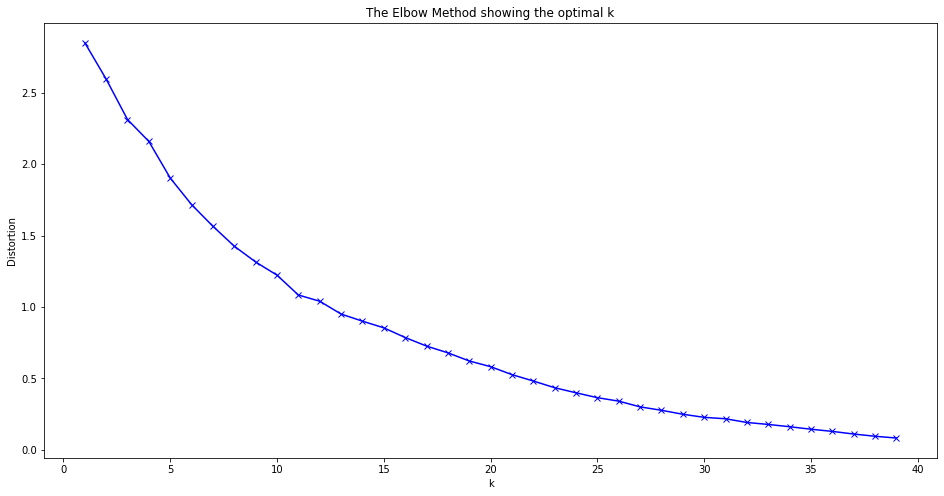

In [259]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [253]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

warsaw_merged = cluster_coords

# merge warsaw_grouped with warsaw_data to add latitude/longitude for each neighborhood
warsaw_merged = warsaw_merged.join(neighborhoods_venues_sorted.set_index('Clusters'), on='Clusters')

print(warsaw_merged.shape)

warsaw_merged.head(7) # check the last columns!

(47, 17)


,Clusters,Latitude,Longitude,SUM,Postcode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,52.179220,21.185115,66,04-883,Wawer,2,Fast Food Restaurant,Grocery Store,Sushi Restaurant,Drugstore,Park,Bistro,Tennis Court,Beer Store,Kebab Restaurant,Discount Store
1,2,52.167989,21.211948,112,04-903,Wawer,2,Grocery Store,Train Station,Convenience Store,Hotel,Deli / Bodega,Coffee Shop,Dessert Shop,Restaurant,Park,Drugstore
2,3,52.210569,21.193962,29,04-744,Wawer,4,Mexican Restaurant,Hotel,Hostel,Italian Restaurant,Zoo Exhibit,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
3,4,52.208223,21.169380,71,04-632,Wawer,2,American Restaurant,Diner,Burger Joint,Food & Drink Shop,Shopping Mall,Mexican Restaurant,Café,Supermarket,Salsa Club,Flower Shop
4,5,52.191335,21.141662,37,04-786,Wawer,2,Bus Stop,Food & Drink Shop,Hotel,Theater,Polish Restaurant,Diner,Park,Fast Food Restaurant,Café,Bus Station
5,6,52.225298,21.149584,103,04-602,Wawer,1,Bus Station,Forest,Pool,Bistro,Eastern European Restaurant,Hotel,Food & Drink Shop,Café,Train Station,Kebab Restaurant
6,7,52.261595,21.163015,74,04-417,Rembertów,1,Supermarket,Light Rail Station,Café,Bus Station,Train Station,Gym Pool,Park,Discount Store,Electronics Store,Event Space


In [249]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(warsaw_merged['Latitude'], warsaw_merged['Longitude'], warsaw_merged['Clusters'], warsaw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters